# At the end of this lesson you will learn:

 - What LSTM networks are
 - Which are their main components
 - Which data problems they are afordable to solve

## What LSTM are

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture used in deep learning. It is designed to capture long-term dependencies and patterns in sequential data, making it especially useful for tasks involving **time series**, natural language processing, speech recognition, and other sequential data.

Unlike traditional RNNs, LSTM networks have a more complex structure that includes memory cells and multiple gates, allowing them to maintain and update long-term and short-term memory states.

https://www.analyticsvidhya.com/blog/2022/03/an-overview-on-long-short-term-memory-lstm/

https://www.youtube.com/watch?v=YCzL96nL7j0



## Components

1- **Cell**: Every unit of the LSTM network is known as a “cell”. Each cell is composed of 3 inputs and 2 outputs.

  INPUTS:
  - $x(t)$ input at timestamp $t$
  - $h(t-1)$ previous hidden state, short memory term
  - $c(t-1)$ previous cell state, long memory term

  OUTPUTS:
  - $h(t)$ updated hidden state, used for predicting the output
  - $c(t)$ current cell state

2- **Gates**: In an LSTM network, gates play curcial role controlling the flow of information through the cells and determining what information should be stored, discarded, or output at each time step. There are three main types of gates in an LSTM:

  - **Forget Gate** ($f_t$): The forget gate determines which parts of the cell state ($C_{t-1}$) should be discarded or forgotten, allowing the LSTM to remove information that is no longer needed.

    $$f_t = σ(W_{if} * x_t + b_{if} + W_{hf} * h_{t-1} + b_{hf})$$
                   

      
 - **Input Gate**($i_t$): The input gate decides which values from the input and the previous hidden state should be used to **update the cell state** ($C_t$). It controls the flow of new information into the cell state.

   $$i_t = σ(W_{ii} * x_t + b_{ii} + W_{hi} * h_{t-1} + b_{hi})$$
   $$C_t = f_t * C_{t-1} + i_t * tanh(W_{ic} * x_t + b_{ic} + W_{hc} * h_{t-1} + b_{hc})$$

- **Output Gate** ($o_t$): This gate updates and finalizes the next hidden state. Since the hidden state contains critical information about previous cell inputs, it decides for the last time which information it should carry for providing the output.

  $$o_t = σ(W_{io} * x_t + b_{io} + W_{ho} * h_{t-1} + b_{ho})$$
  $$h_t = o_t * tanh(C_t)$$



Where:

- $f_t$ is the forget gate's output (ranging from 0 to 1).
- $x_t$ is the current input.
- $h_{t-1}$ is the previous hidden state.
- $σ$ represents the sigmoid activation function.
- $W_{if}, W_{hf}, b_{if}$ and $b_{hf}$ are weights matrices.

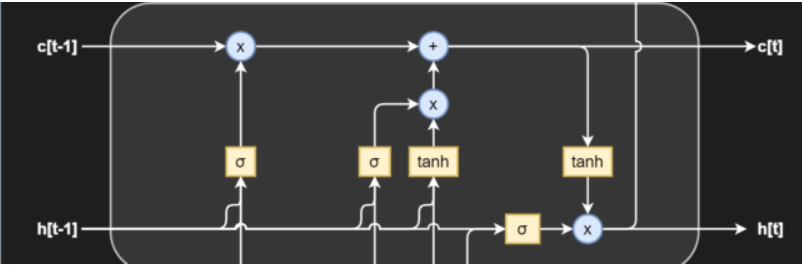

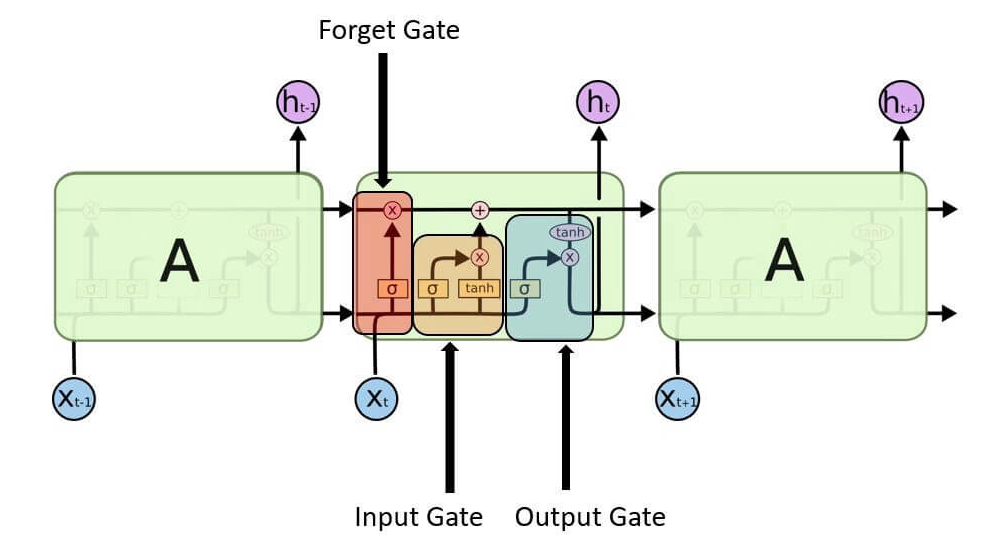

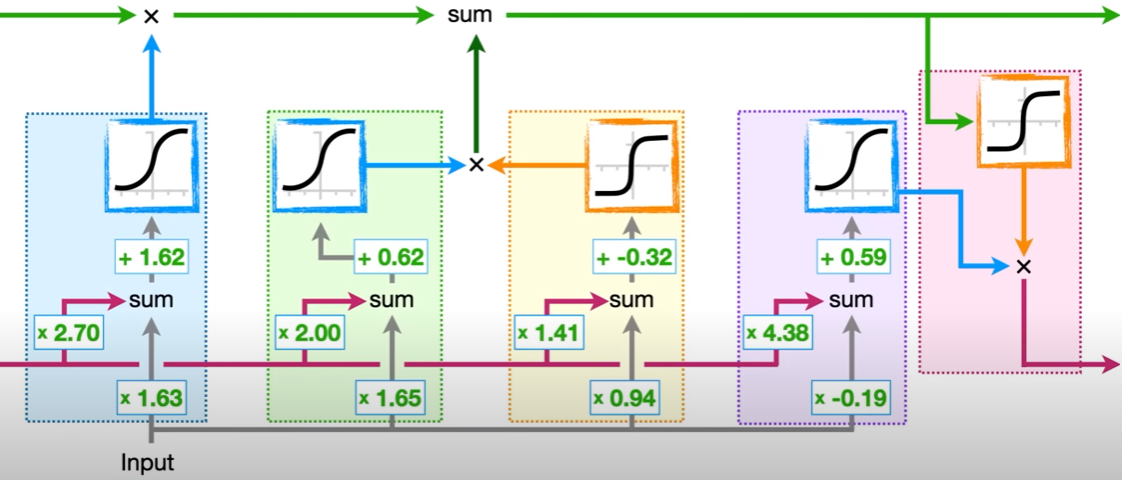

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

In [2]:
weather = pd.read_csv('/content/sample_data/Barcelona_weather.csv', sep = ';')

weather['date'] = pd.to_datetime(weather['dt'],unit='s')
weather = weather[['date','temp','feels_like','pressure','humidity','wind_speed','dew_point', 'visibility','rain_1h']]
weather['rain_1h'].fillna(0, inplace = True)
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather = weather[weather['year'].isin([2018,2019,2020,2021,2022])]

def nans(df):
  for c in df.columns:
    df[c].bfill(inplace = True)
  return df

weather = nans(weather)

weather.drop_duplicates(inplace = True)
weather.reset_index(inplace = True)
weather.drop(['index'], axis = 1, inplace = True);
weather.head(3)


<ipython-input-2-0363d6bef513>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c].bfill(inplace = True)
<ipython-input-2-0363d6bef513>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.drop_duplicates(inplace = True)
<ipython-input-2-0363d6bef513>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.drop(['index'], axis = 1, inplace = True);


,date,temp,feels_like,pressure,humidity,wind_speed,dew_point,visibility,rain_1h,year,month
0,2018-01-01 00:00:00,14.63,13.61,1018,56,9.3,5.96,10000.0,0.0,2018,1
1,2018-01-01 01:00:00,13.31,12.05,1019,52,6.7,3.67,10000.0,0.0,2018,1
2,2018-01-01 02:00:00,12.35,11.10,1020,56,6.7,3.83,10000.0,0.0,2018,1


In [42]:
weather.columns

Index(['date', 'temp', 'feels_like', 'pressure', 'humidity', 'wind_speed',
       'dew_point', 'visibility', 'rain_1h', 'year', 'month'],
      dtype='object')

In [43]:
weather.year.value_counts()

2020    8784
2018    8760
2019    8760
2021    8760
2022    8760
Name: year, dtype: int64

In [3]:
# 8860 instantes de tiempo (horas) para validar equivalentes a todo el año 2022
X_train = weather[['temp', 'visibility','dew_point', 'pressure','humidity', 'wind_speed', 'feels_like']][:-8760]
y_train = weather[['temp']][:-8760]


X_test = weather[['temp', 'visibility','dew_point', 'pressure','humidity', 'wind_speed', 'feels_like']][8760:]
y_test = weather[['temp']][8760:]

# temp_train = np.array(weather['temp'][:-8760]).reshape(-1, 1)
# temp_test = np.array(weather['temp'][8760:]).reshape(-1, 1)

temp_train = weather[['temp']][:-8760]
temp_test = weather[['temp']][8760:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(temp_train.shape, temp_test.shape)

(35064, 7) (35064, 1)
(35064, 7) (35064, 1)
(35064, 1) (35064, 1)


In [4]:
scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(test_sc)
X_test_sc.columns = X_test.columns

print(X_train_sc.shape, y_train.shape)
print(X_test_sc.shape, y_test.shape)

(35064, 7) (35064, 1)
(35064, 7) (35064, 1)


In [5]:
# Esta función agrupa los instantes de tiempo en bloques de tamaño `time_steps`
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
      v = X.iloc[i:(i + time_steps)].values
      Xs.append(v)
      ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train_shape, y_train_shape = create_dataset(X_train_sc, y_train, time_steps)
X_test_shape, y_test_shape = create_dataset(X_test_sc, y_test, time_steps)

X_temp_train_shape, y_temp_train_shape = create_dataset(temp_train, y_train, time_steps)
X_temp_test_shape, y_temp_test_shape = create_dataset(temp_test, y_test, time_steps)

print(X_train_shape.shape, y_train.shape)
print(X_test_shape.shape, y_test.shape)

print(X_temp_train_shape.shape, y_temp_train_shape.shape)
print(X_temp_test_shape.shape, y_temp_test_shape.shape)

(35063, 1, 7) (35064, 1)
(35063, 1, 7) (35064, 1)
(35063, 1, 1) (35063, 1)
(35063, 1, 1) (35063, 1)


In [ ]:
X_temp_train_shape[0:48]

In [20]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(12,activation='tanh', input_shape = (X_train_shape.shape[1], X_train_shape.shape[2])),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
  ])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history = lstm_model.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape), epochs=50, batch_size = 100)

ypred_shape = lstm_model.predict(X_test_shape)

_, mae_tr, mape_tr = lstm_model.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = lstm_model.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/50
351/351 [==============================] - 6s 8ms/step - loss: 304.4561 - mean_absolute_error: 16.5151 - mean_absolute_percentage_error: 94.4719 - val_loss: 254.2559 - val_mean_absolute_error: 15.1861 - val_mean_absolute_percentage_error: 86.2387
Epoch 2/50
351/351 [==============================] - 3s 7ms/step - loss: 194.0620 - mean_absolute_error: 13.2644 - mean_absolute_percentage_error: 77.0562 - val_loss: 150.8053 - val_mean_absolute_error: 11.7545 - val_mean_absolute_percentage_error: 67.9793
Epoch 3/50
351/351 [==============================] - 2s 6ms/step - loss: 111.4670 - mean_absolute_error: 10.0375 - mean_absolute_percentage_error: 58.9129 - val_loss: 82.7762 - val_mean_absolute_error: 8.6247 - val_mean_absolute_percentage_error: 49.7666
Epoch 4/50
351/351 [==============================] - 2s 5ms/step - loss: 56.8421 - mean_absolute_error: 6.9915 - mean_absolute_percentage_error: 40.4318 - val_loss: 38.8814 - val_mean_absolute_error: 5.6496 - val_mean_absolute_

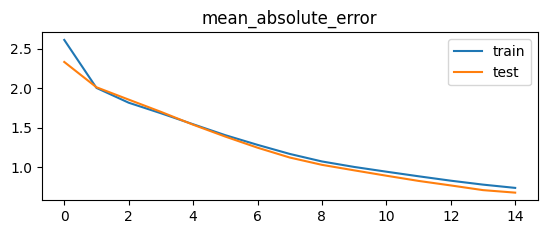

In [17]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'][5:], label='train')
plt.plot(history.history['val_mean_absolute_error'][5:], label='test')
plt.legend()

## Using only temperature as predictive

In [12]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(12,activation='tanh', input_shape = (X_temp_train_shape.shape[1], X_temp_train_shape.shape[2])),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
  ])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history = lstm_model.fit(X_temp_train_shape, y_temp_train_shape, validation_data = (X_temp_test_shape, y_temp_test_shape), epochs=20, batch_size = 100)

ypred_temp = lstm_model.predict(X_temp_test_shape)

_, mae_tr, mape_tr = lstm_model.evaluate(X_temp_train_shape, y_temp_train_shape)
_, mae_ts, mape_ts = lstm_model.evaluate(X_temp_test_shape, y_temp_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/20
351/351 [==============================] - 9s 18ms/step - loss: 252.5059 - mean_absolute_error: 14.4158 - mean_absolute_percentage_error: 78.7950 - val_loss: 148.6941 - val_mean_absolute_error: 10.5069 - val_mean_absolute_percentage_error: 52.9970
Epoch 2/20
351/351 [==============================] - 5s 15ms/step - loss: 97.4031 - mean_absolute_error: 7.9451 - mean_absolute_percentage_error: 38.9920 - val_loss: 67.8236 - val_mean_absolute_error: 6.2024 - val_mean_absolute_percentage_error: 28.2541
Epoch 3/20
351/351 [==============================] - 6s 18ms/step - loss: 47.7394 - mean_absolute_error: 4.9751 - mean_absolute_percentage_error: 22.8565 - val_loss: 37.8286 - val_mean_absolute_error: 4.2242 - val_mean_absolute_percentage_error: 18.4339
Epoch 4/20
351/351 [==============================] - 6s 18ms/step - loss: 26.8072 - mean_absolute_error: 3.4511 - mean_absolute_percentage_error: 15.5331 - val_loss: 22.0121 - val_mean_absolute_error: 3.0070 - val_mean_absolute_pe

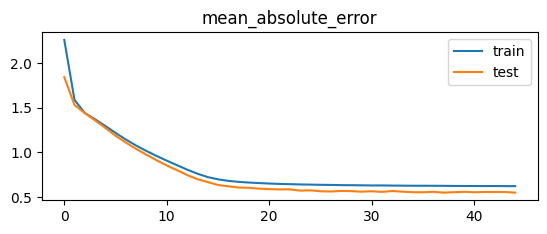

In [22]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'][5:], label='train')
plt.plot(history.history['val_mean_absolute_error'][5:], label='test')
plt.legend()

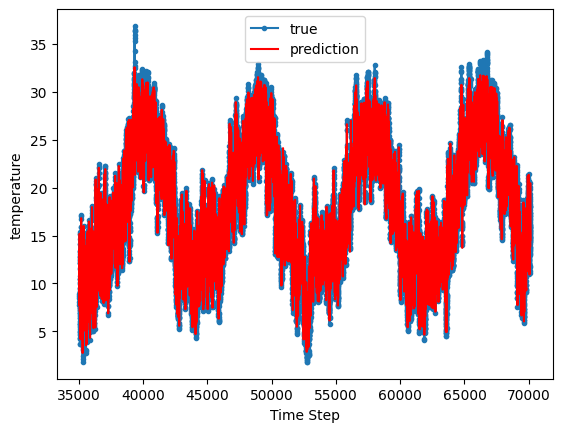

In [21]:
# plt.plot(np.arange(0, len(y_train_shape)), y_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), y_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('temperature')
plt.xlabel('Time Step')
plt.legend()
plt.show();

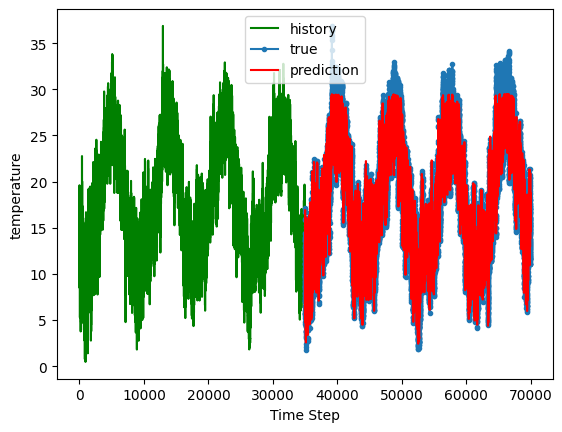

In [351]:
plt.plot(np.arange(0, len(y_temp_train_shape)), y_temp_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_temp_train_shape), len(y_temp_train_shape) + len(y_temp_test_shape)), y_temp_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_temp_train_shape), len(y_temp_train_shape) + len(y_temp_test_shape)), ypred_temp.flatten(), 'r', label="prediction")
plt.ylabel('temperature')
plt.xlabel('Time Step')
plt.legend()
plt.show();